In [1]:
!python --version

Python 3.9.12


In [2]:
!pip install torch torchvision

In [3]:
import torch
import h5py
import os
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.utils.data as data_utils

In [4]:
class PatchCamelyon(data_utils.Dataset):

    def __init__(self, mode='train', batch_size=32, n_iters=None, augment=False):
            super().__init__()

            self.n_iters = n_iters
            self.batch_size = batch_size

            assert mode in ['train', 'valid', 'test']
            base_name = "camelyonpatch_level_2_split_{}_{}.h5"

            print('\n')
            print("# " * 50)
            print('Loading {} dataset...'.format(mode))

            # Open the files
            self.h5X = h5py.File(os.path.join(base_name.format(mode, 'x')), 'r')
            self.h5y = h5py.File(os.path.join(base_name.format(mode, 'y')), 'r')

            print("# " * 50)

            if augment:
                self.transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.ColorJitter(brightness=.5, saturation=.25, hue=.1, contrast=.5),
                                                     transforms.RandomAffine(10, (0.05, 0.05), fillcolor=(255, 255, 255)),
                                                     transforms.RandomHorizontalFlip(.5),
                                                     transforms.RandomVerticalFlip(.5),
                                                     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]
                                                   )
            else:
                self.transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

    def __getitem__(self, idx):
        # size: 96x96x3
        image = np.array(self.h5X.get("x")[idx])
        # size: 1
        label = torch.tensor(self.h5y.get("y")[idx]).view(-1)
        
        image = self.transform(image)
        return image, label

    def __len__(self):
        #return len(self.X) // self.batch_size
        return len(self.h5X.get("x"))


In [7]:
import matplotlib.pyplot as plt

def loss(prediction, target):

    w1 = 1.33  # False negative penalty
    w2 = .66  # False positive penalty

    return -torch.mean(w1 * target * torch.log(prediction.clamp_min(1e-3))
                       + w2 * (1. - target) * torch.log(1. - prediction.clamp_max(.999)))

env = 'main'
plots = {}

def plot(var_name, split_name, title_name, x, y):
    

    plt.figure(figsize=(10,5))
    plt.title(f'{title_name}')
    plt.plot(x, y, label=f'{split_name}')
    plt.xlabel(f'{var_name}')
    plt.ylabel(f'{split_name}')
    plt.legend()
    plt.show()

def sliding_window(image_shape, window_shape, stride=None):

    if stride is None:
        stride = (window_shape[0], window_shape[1])

    # Padding
    padding_x = 0 if image_shape[1] % window_shape[1] == 0 else window_shape[1] - image_shape[1] % window_shape[1]
    padding_y = 0 if image_shape[0] % window_shape[0] == 0 else window_shape[0] - image_shape[0] % window_shape[0]
    padded_shape = (image_shape[0] + padding_y, image_shape[1] + padding_x)

    x = np.arange(0, padded_shape[1], stride[1])
    y = np.arange(0, padded_shape[0], stride[0])

    x1, y1 = np.meshgrid(x, y)

    x2 = x1 + window_shape[1]
    y2 = y1 + window_shape[0]

    return np.stack([x1, y1, x2, y2], axis=2), {'x': padding_x, 'y': padding_y}

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class CamelyonClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        backbone = models.mobilenet_v2(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.pool = nn.MaxPool2d(3, 1)
        #self.fc = nn.Sequential(nn.Linear(1280, 1), nn.Sigmoid())
        self.fc = nn.Sequential(nn.Linear(1280, 1))

        n_params = sum([p.numel() for p in self.parameters()])

        print("\n")
        print("# " * 50)
        print("MobileNet v2 initialized with {:.3e} parameters".format(n_params))
        print("# " * 50)
        print("\n")

    def forward(self, x):

        return self.fc(self.pool(self.backbone(x)).view(x.shape[0], -1))

    def print_modules(self):
        for idx, param in enumerate(self.modules()):
            print("Module : ", idx)
            print(param)
            print("\n")


if __name__ == '__main__':

    zeros = torch.zeros((2, 3, 96, 96))
    model = CamelyonClassifier()
    print(model(zeros).shape)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
MobileNet v2 initialized with 2.225e+06 parameters
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


torch.Size([2, 1])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


/Users/darwe001/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/darwe001/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
MobileNet v2 initialized with 2.225e+06 parameters
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Loading train dataset...
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Loading valid dataset...
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
 acc 0.8575490196078431
 list acc [0.8575490196078431]


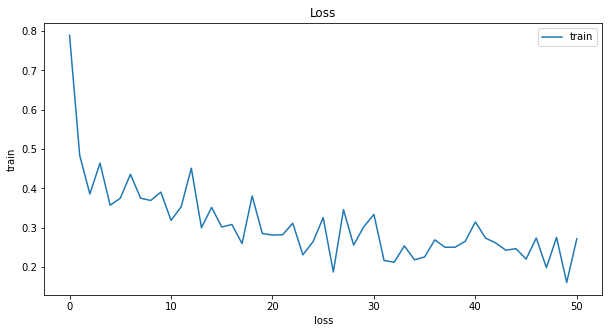

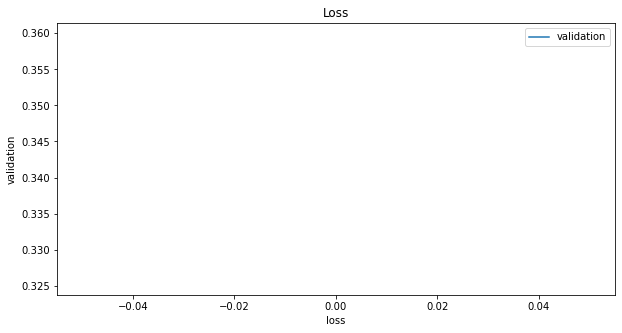

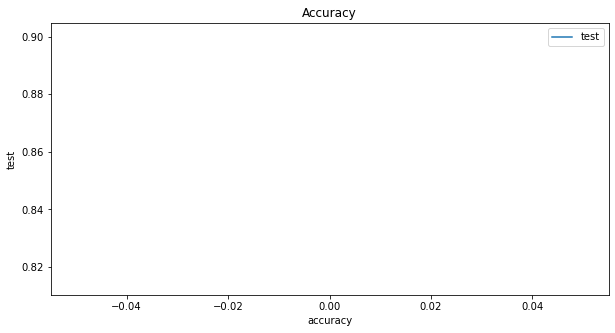

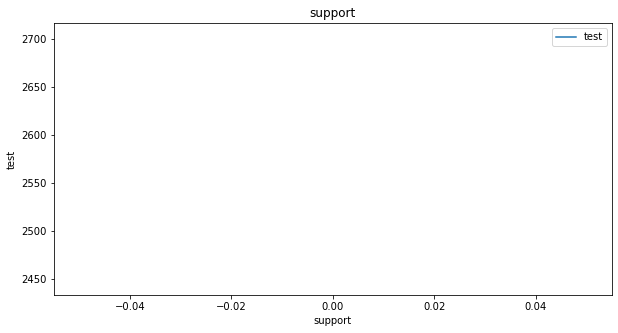

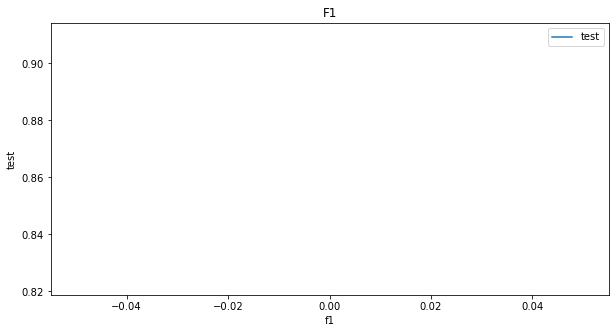

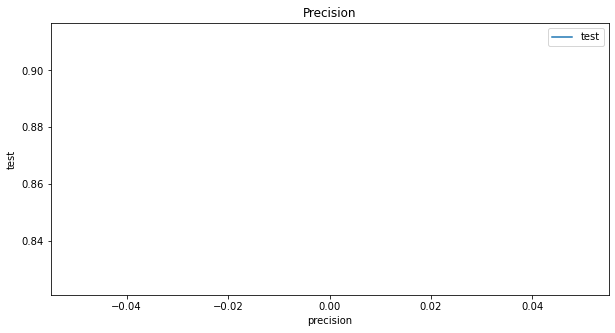


Iteration: 0050 of 10000		 Valid Loss: 0.3426

 acc 0.86098039215686273
 list acc [0.8575490196078431, 0.8609803921568627]


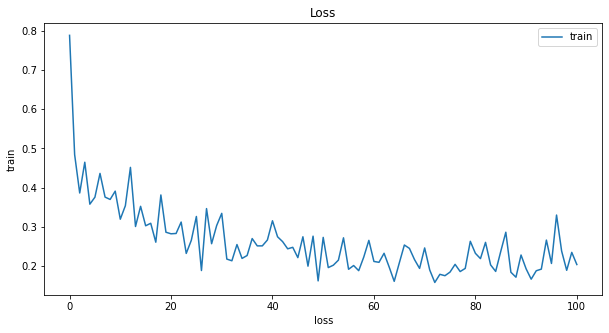

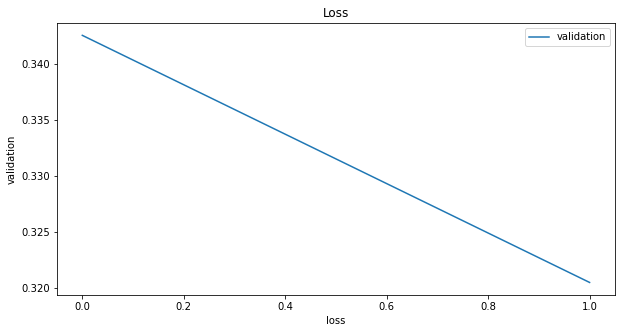

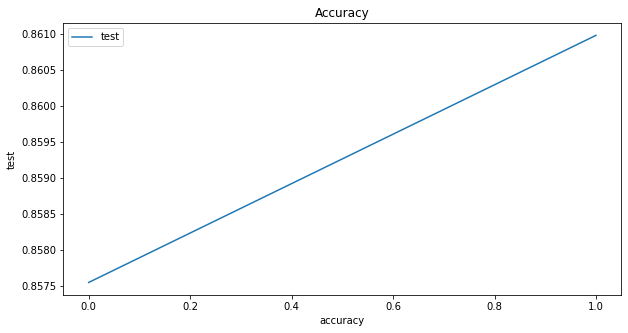

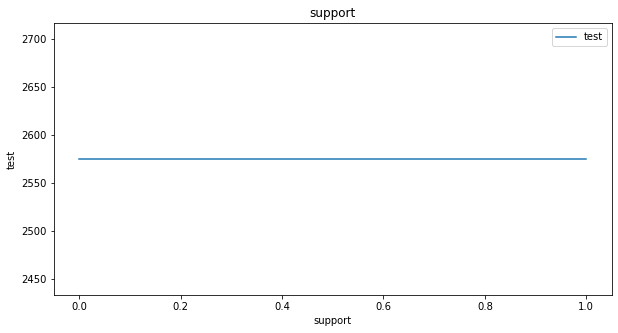

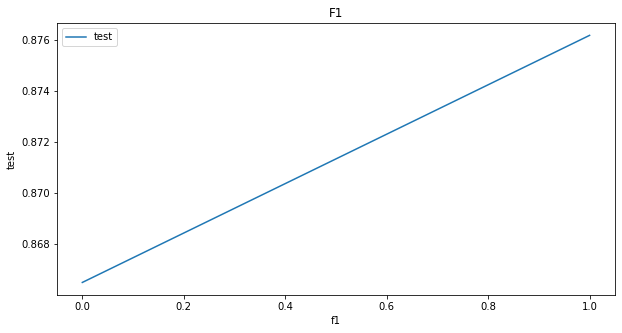

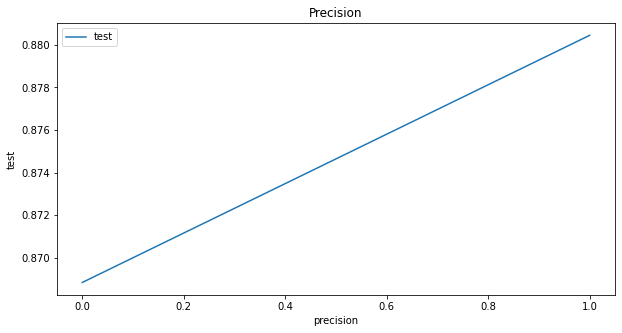


Iteration: 0100 of 10000		 Valid Loss: 0.3205

 acc 0.88568627450980397
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039]


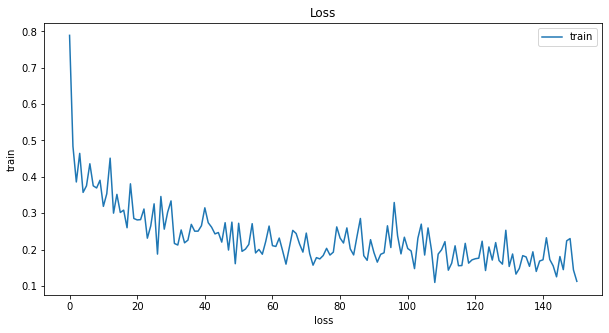

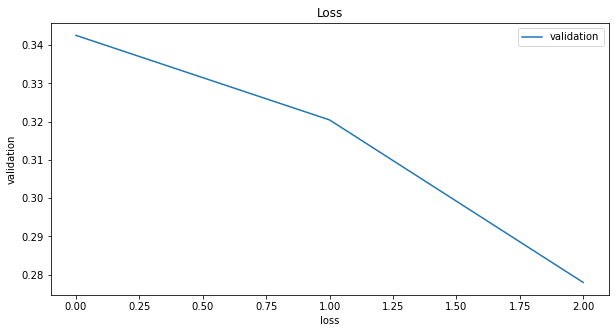

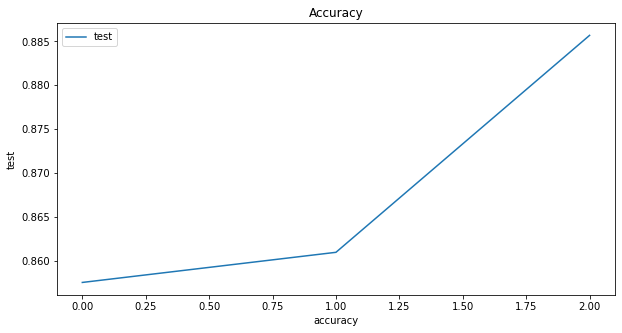

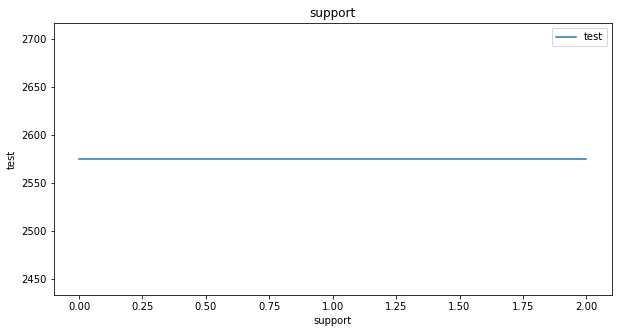

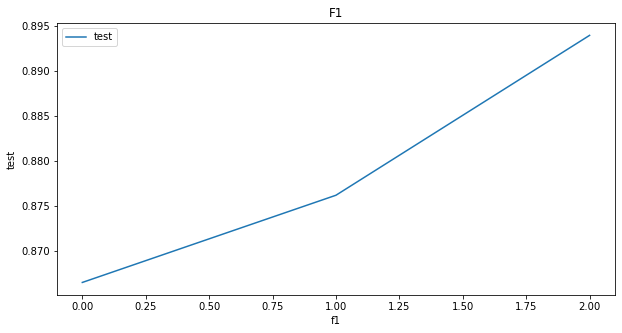

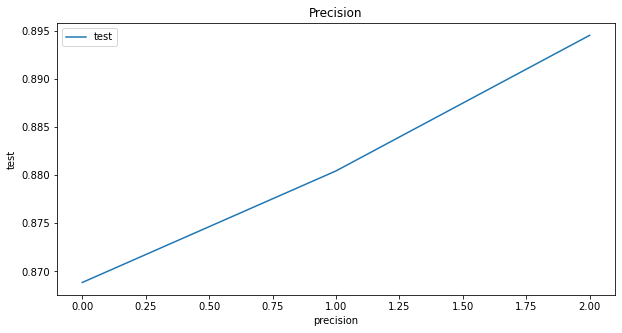


Iteration: 0150 of 10000		 Valid Loss: 0.2780

 acc 0.86558823529411756
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175]


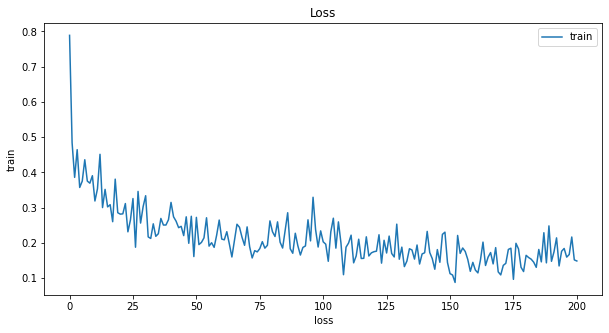

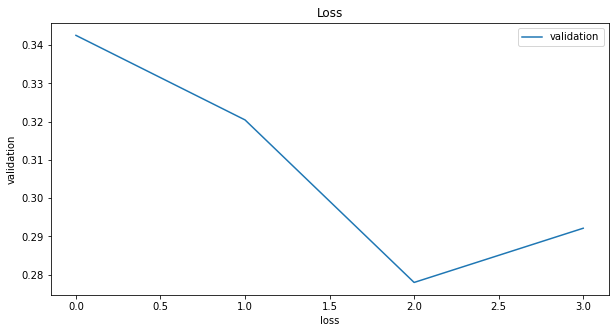

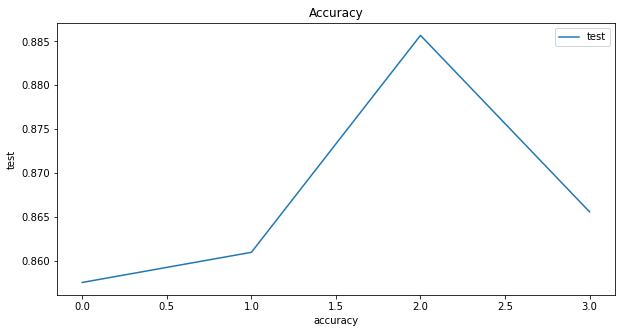

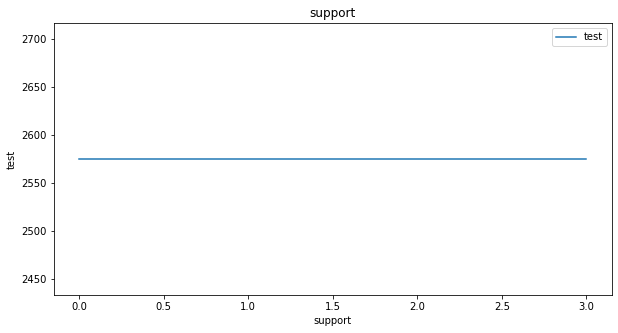

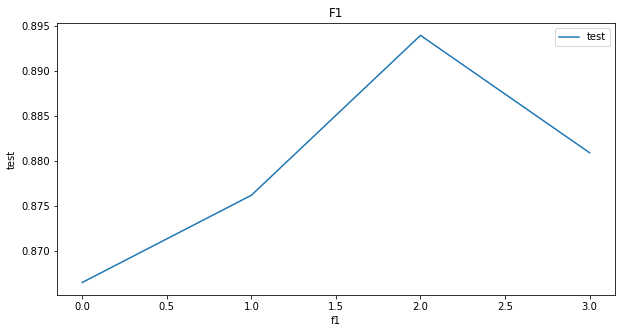

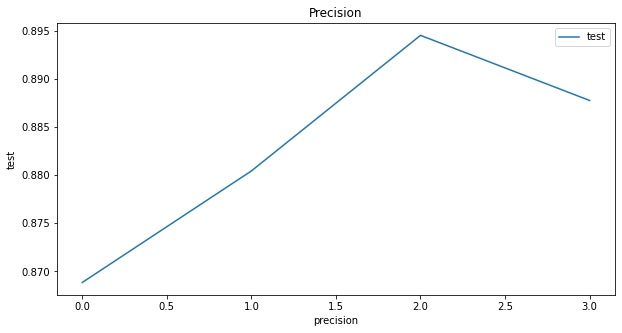


Iteration: 0200 of 10000		 Valid Loss: 0.2921

 acc 0.86598039215686274
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627]


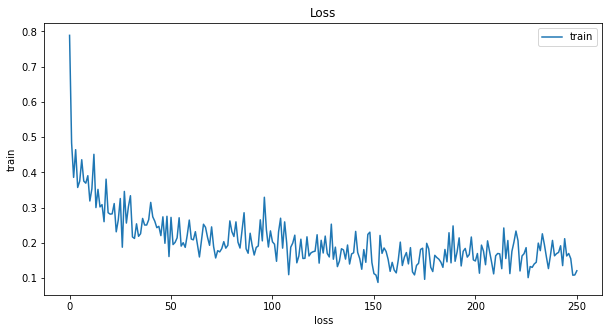

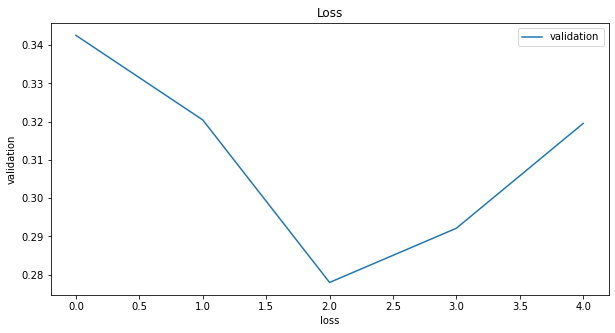

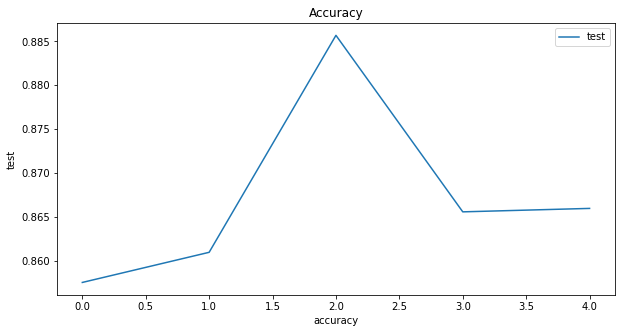

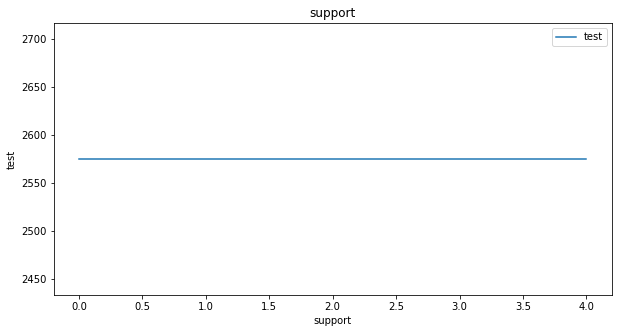

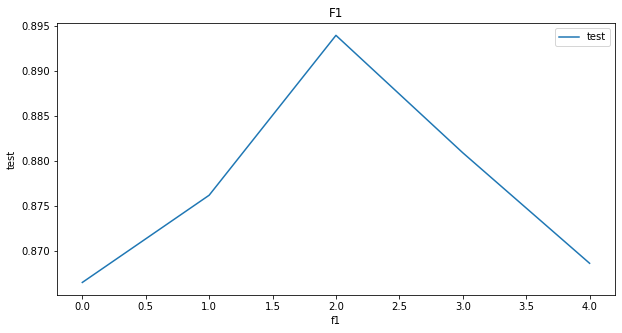

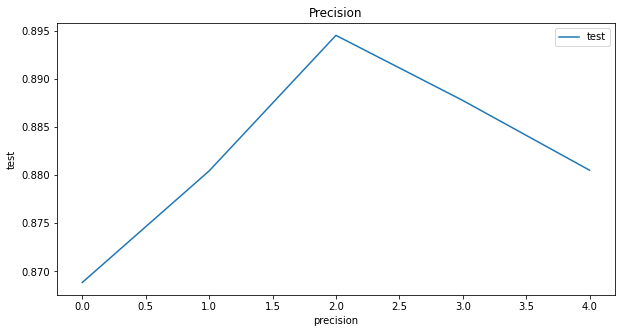


Iteration: 0250 of 10000		 Valid Loss: 0.3196

 acc 0.87117647058823543
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354]


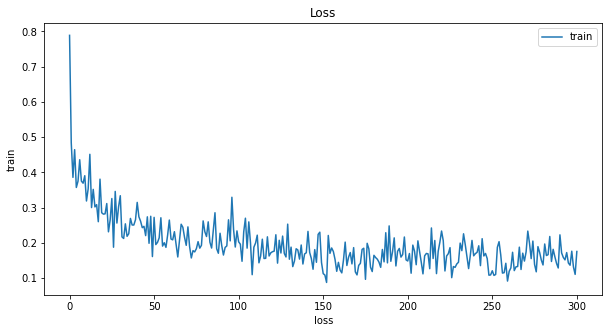

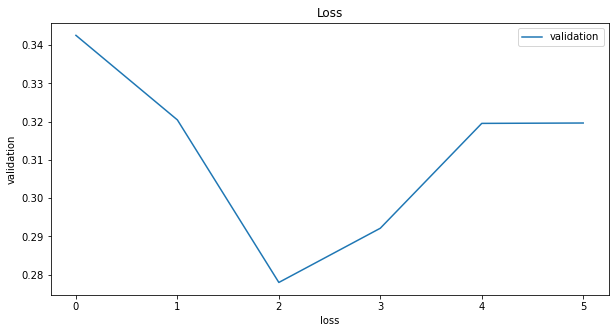

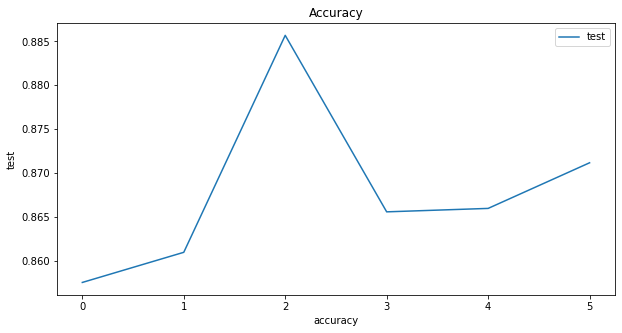

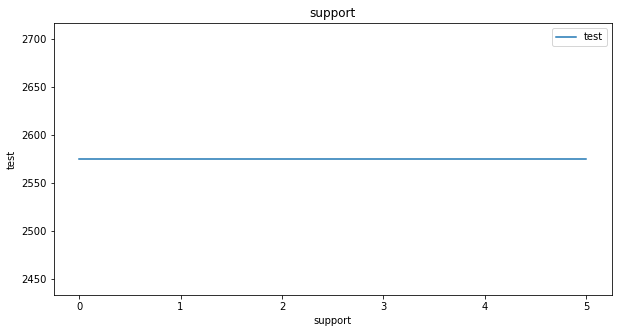

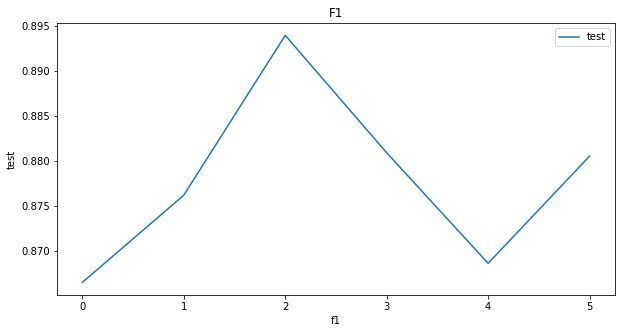

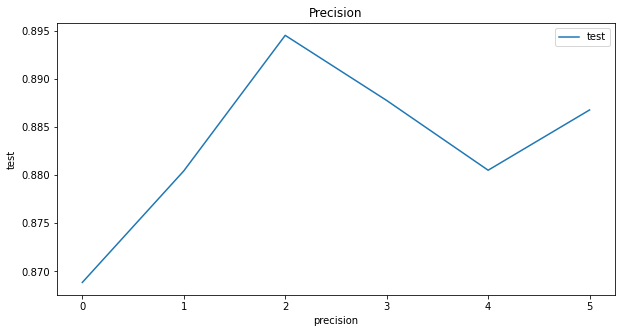


Iteration: 0300 of 10000		 Valid Loss: 0.3197

 acc 0.87147058823529411
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941]


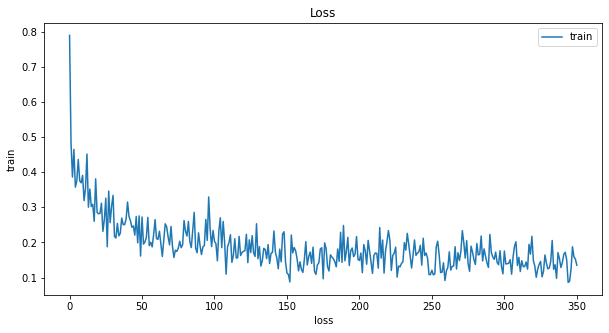

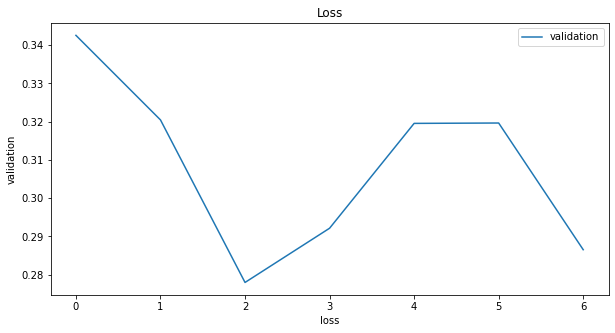

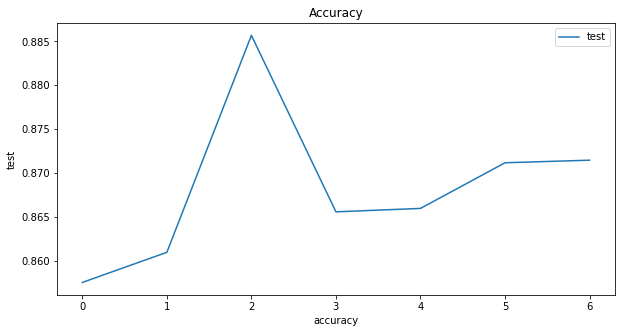

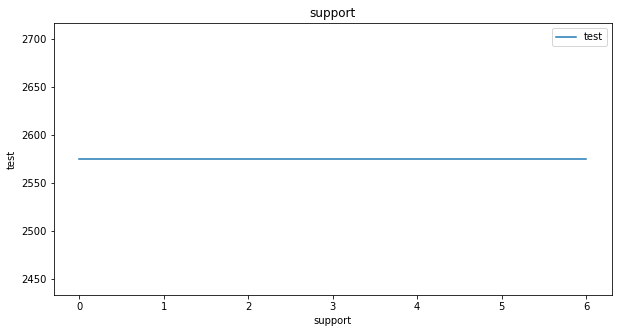

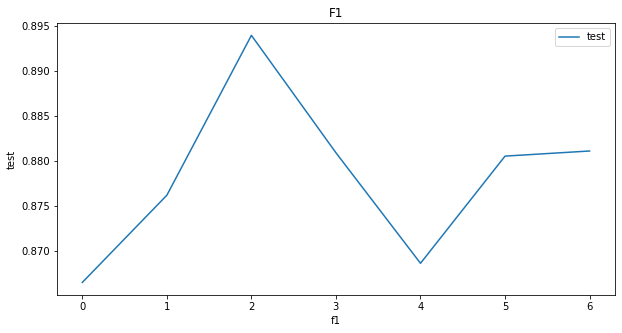

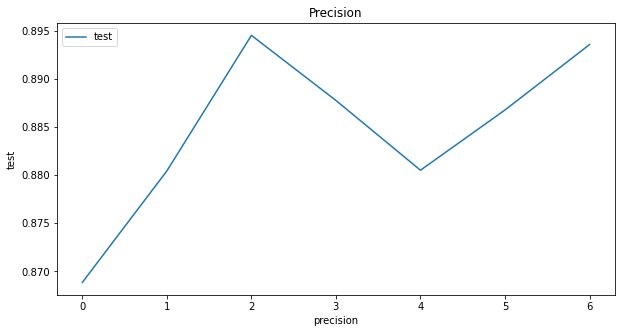


Iteration: 0350 of 10000		 Valid Loss: 0.2865

 acc 0.82539215686274538
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453]


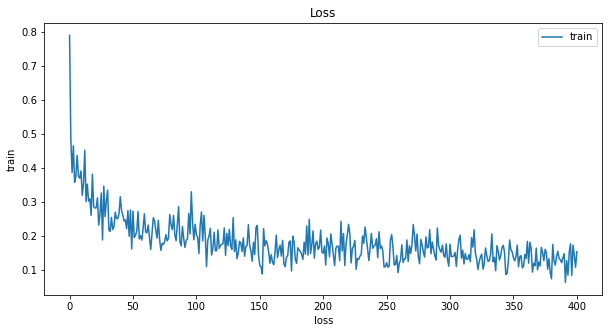

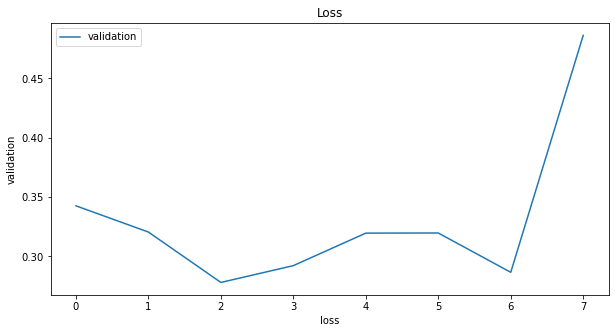

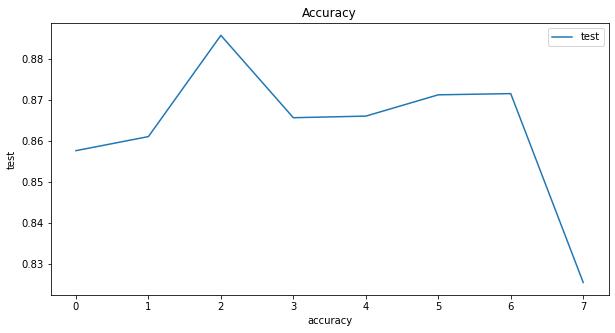

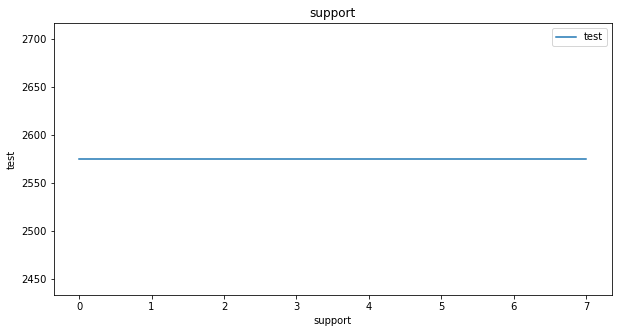

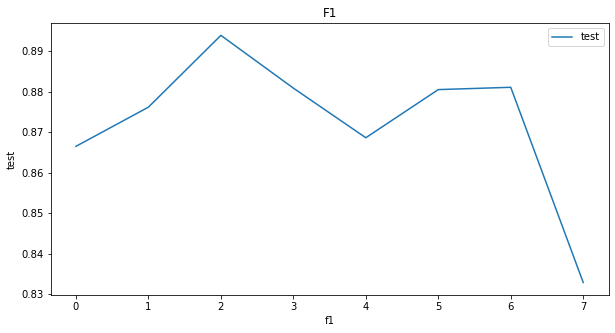

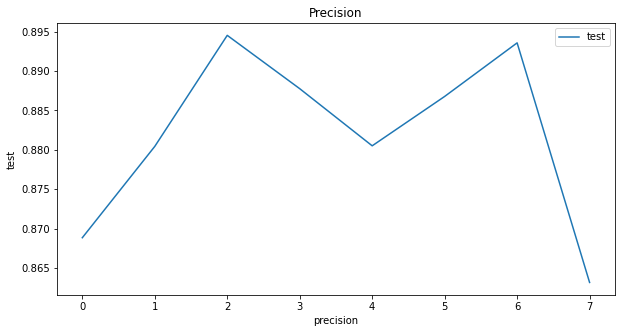


Iteration: 0400 of 10000		 Valid Loss: 0.4864

 acc 0.87264705882352926
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292]


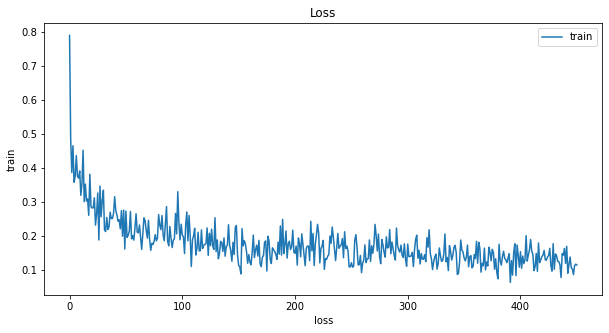

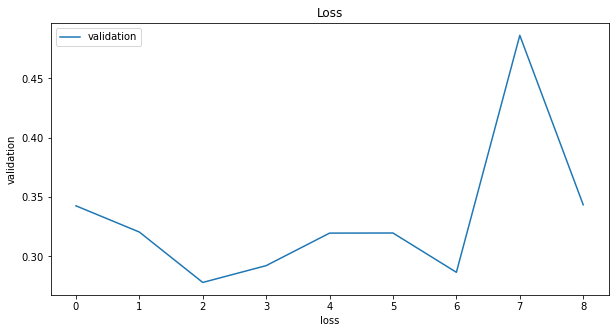

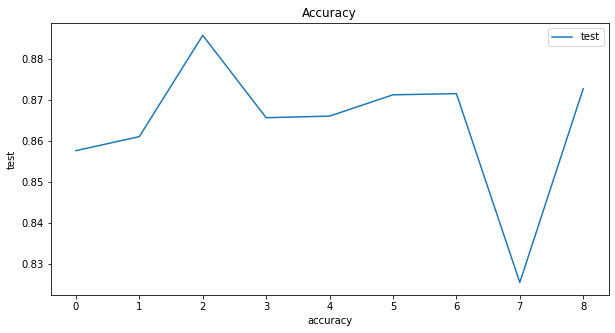

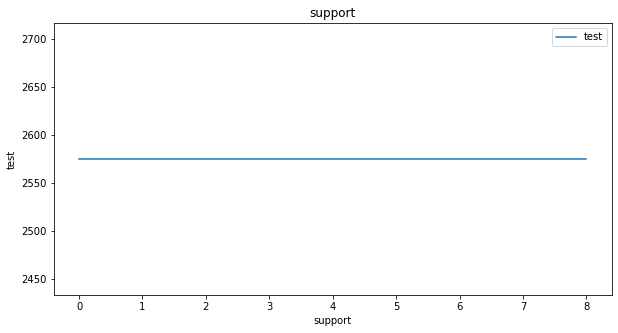

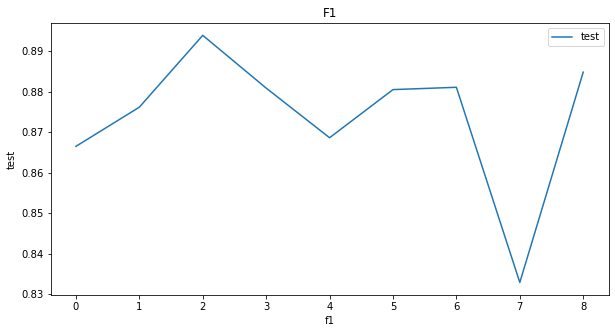

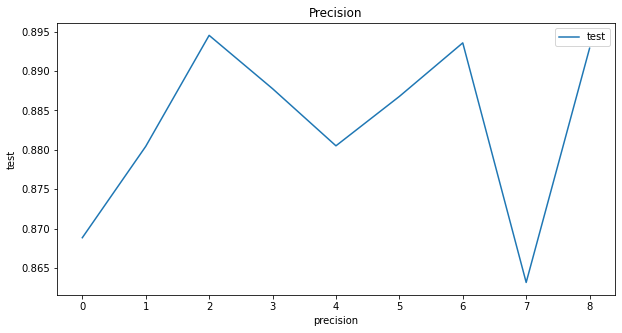


Iteration: 0450 of 10000		 Valid Loss: 0.3435

 acc 0.85735294117647046
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704]


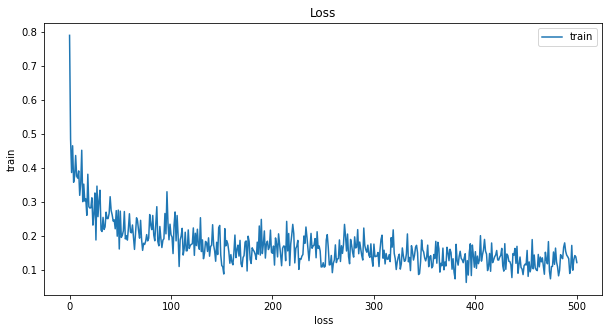

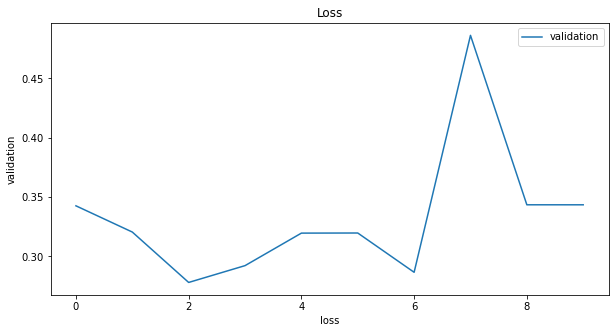

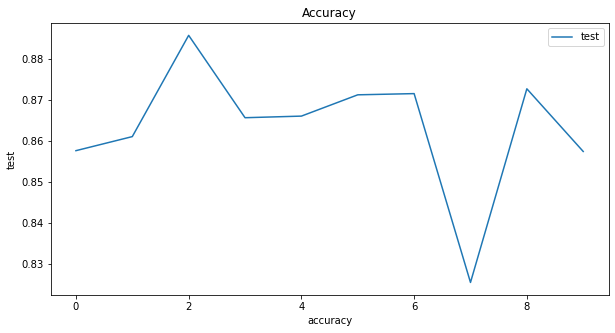

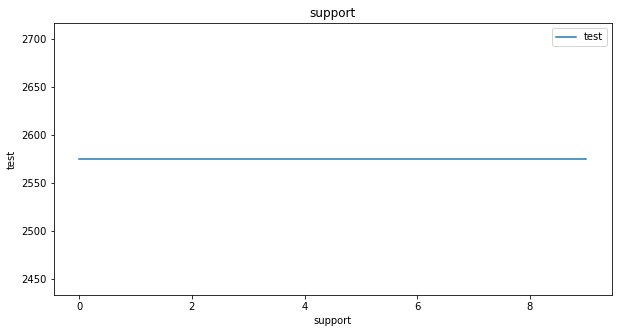

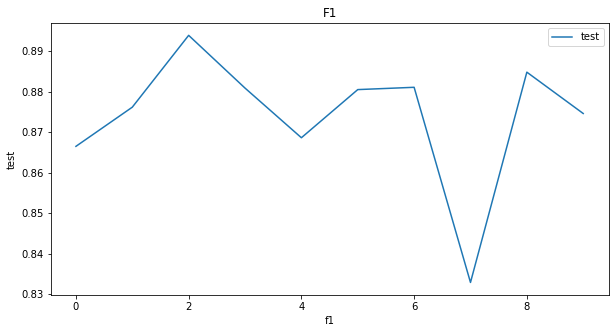

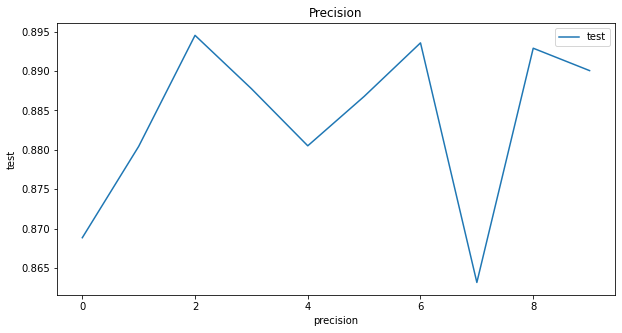


Iteration: 0500 of 10000		 Valid Loss: 0.3434

 acc 0.87294117647058817
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881]


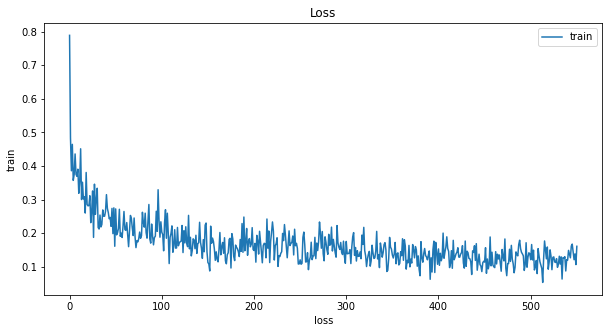

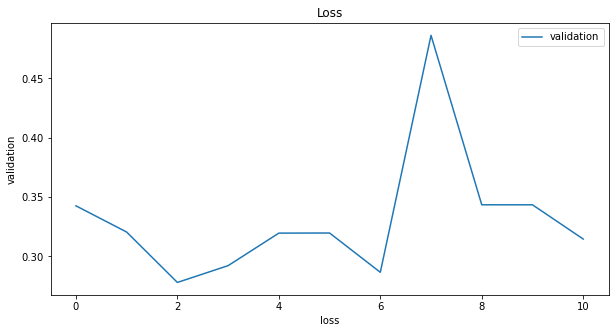

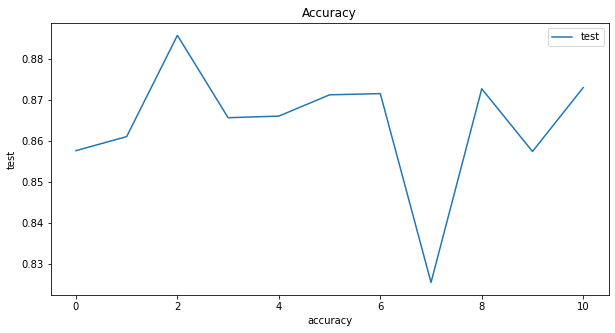

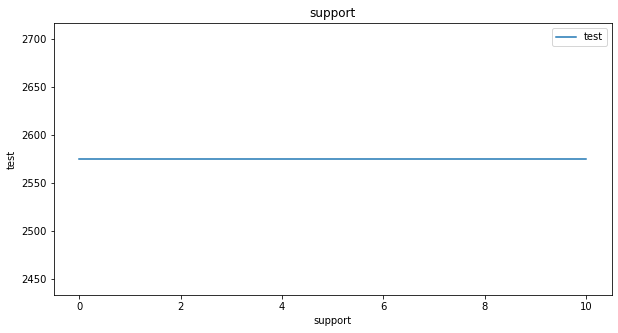

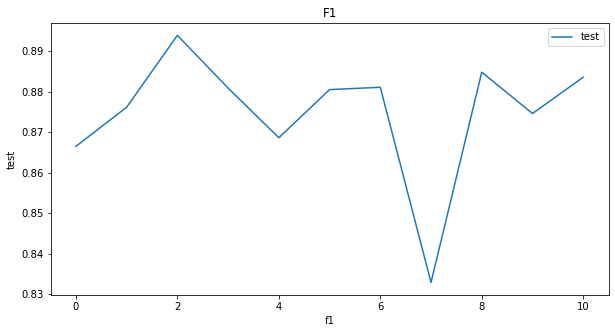

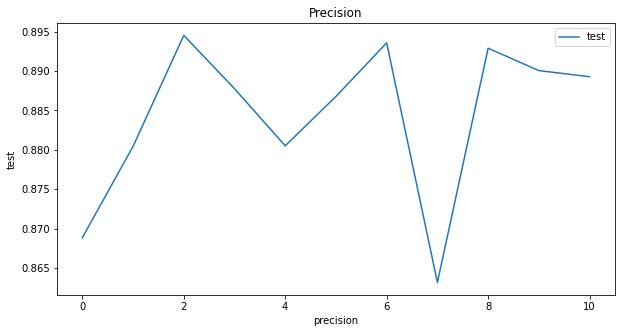


Iteration: 0550 of 10000		 Valid Loss: 0.3146

 acc 0.83784313725490216
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902]


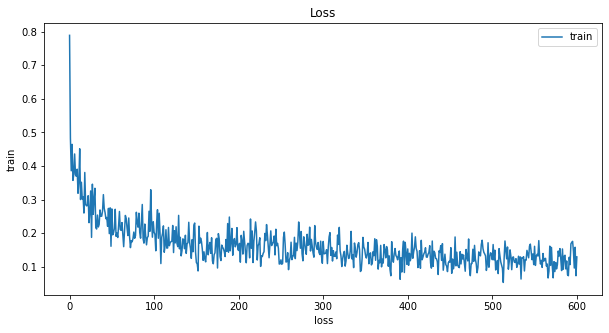

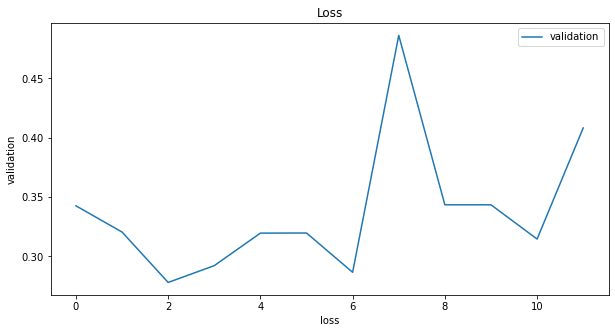

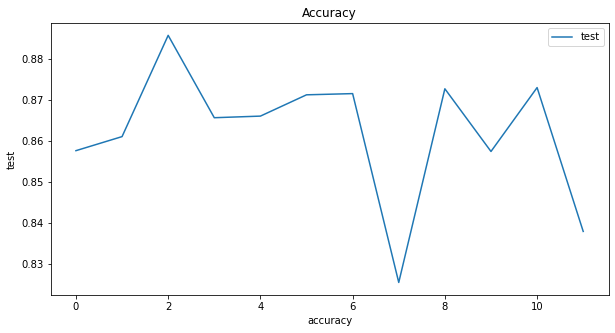

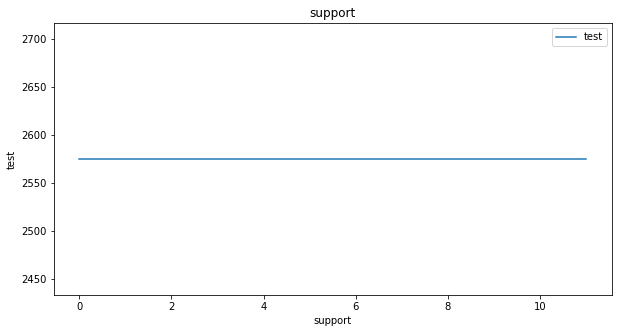

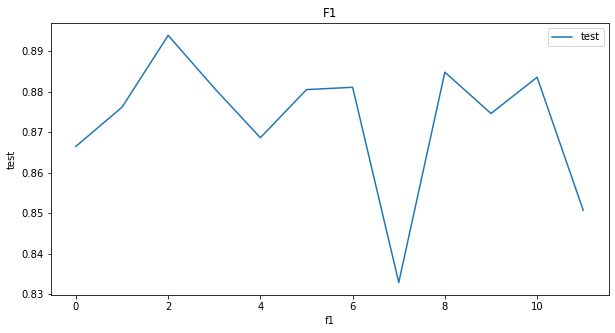

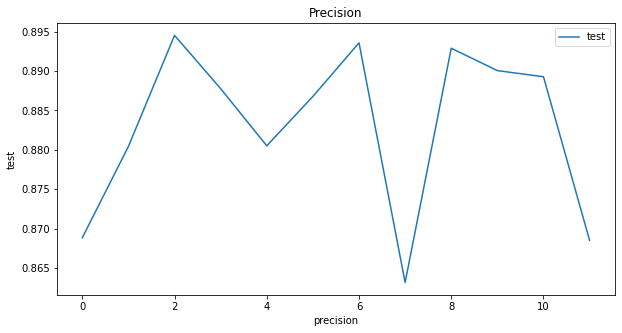


Iteration: 0600 of 10000		 Valid Loss: 0.4083

 acc 0.83450980392156872
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687]


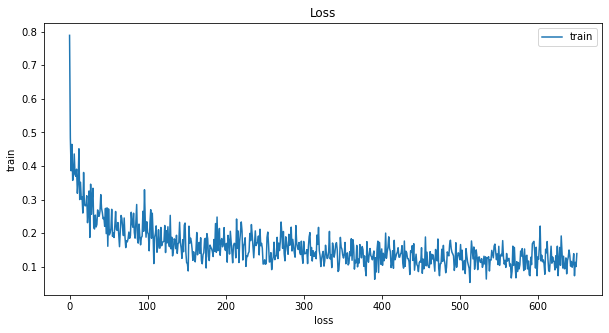

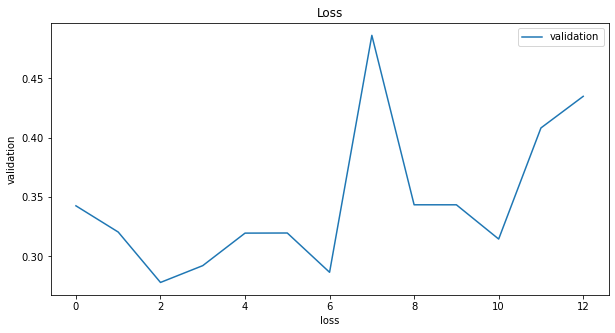

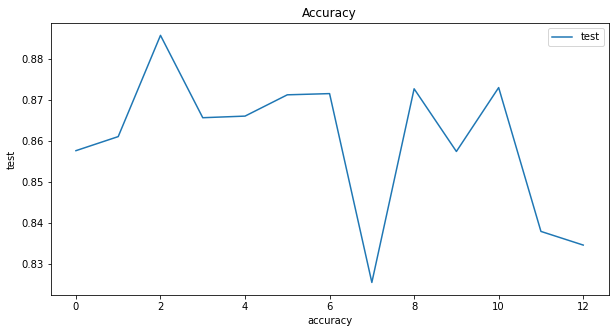

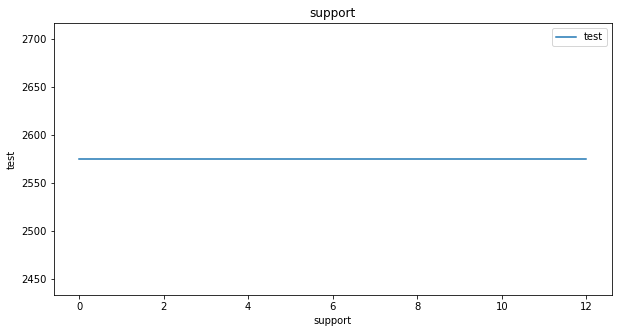

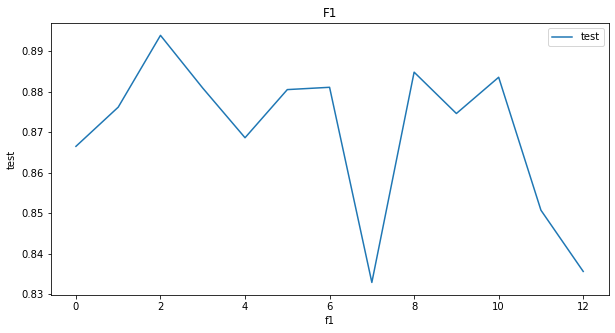

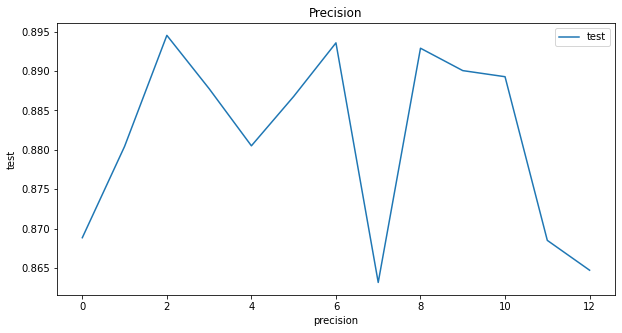


Iteration: 0650 of 10000		 Valid Loss: 0.4349

 acc 0.85598039215686368
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863]


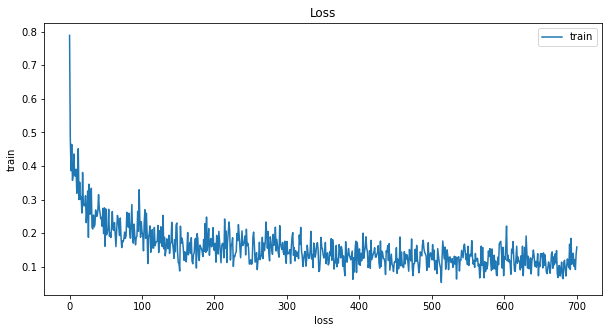

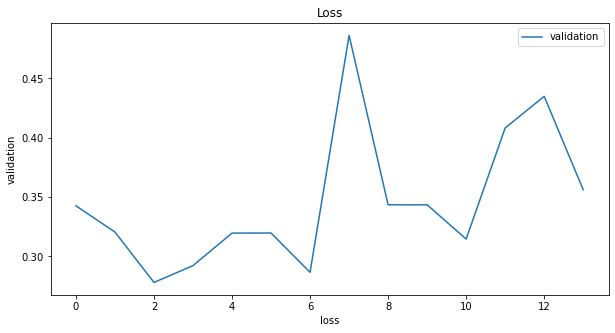

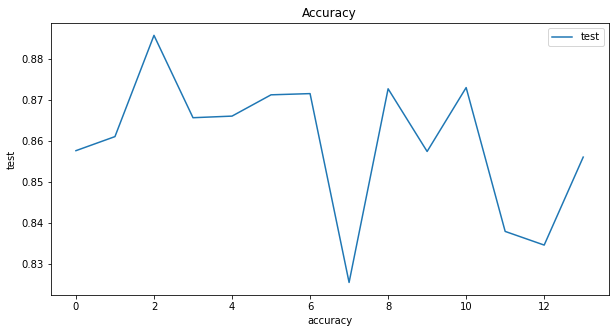

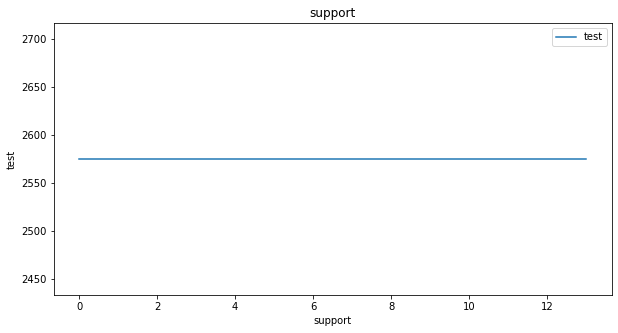

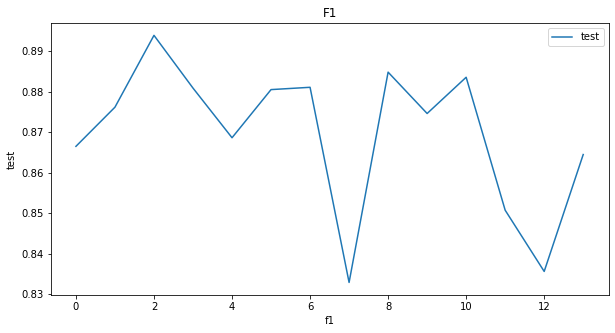

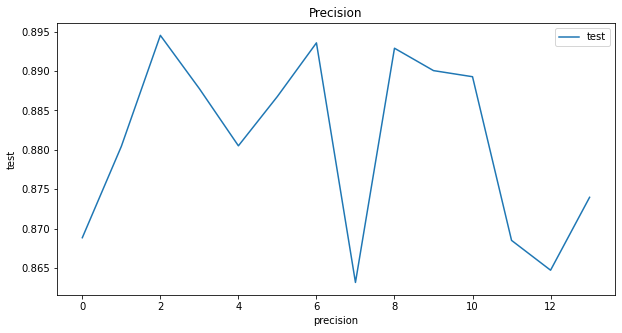


Iteration: 0700 of 10000		 Valid Loss: 0.3562

 acc 0.81980392156862749
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274]


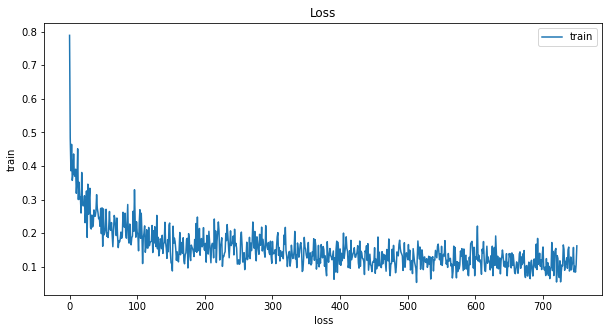

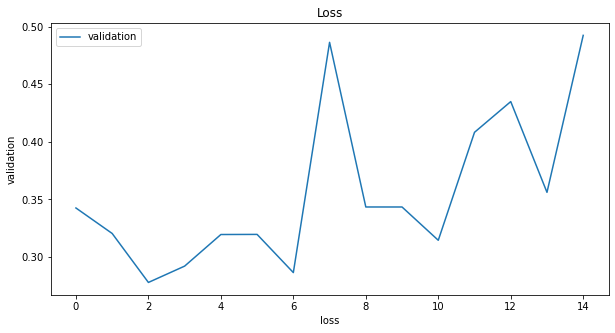

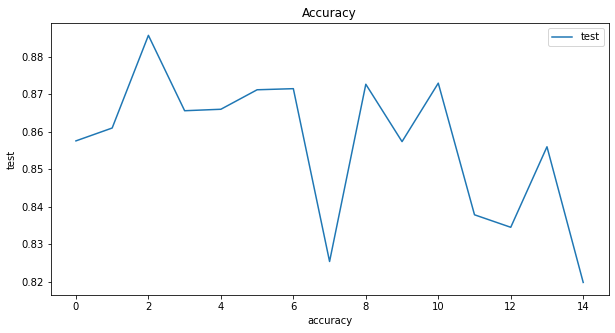

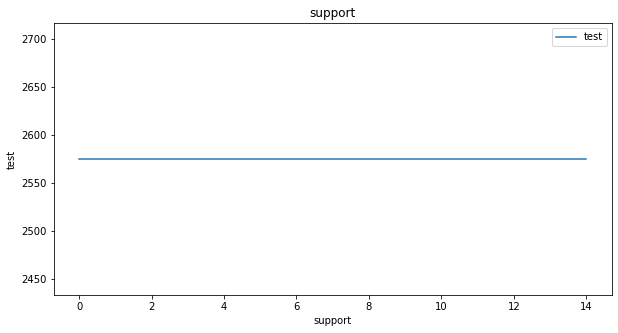

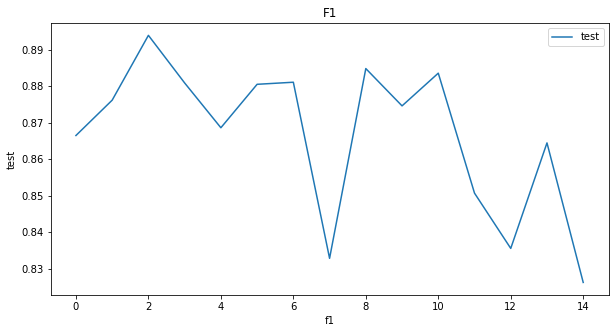

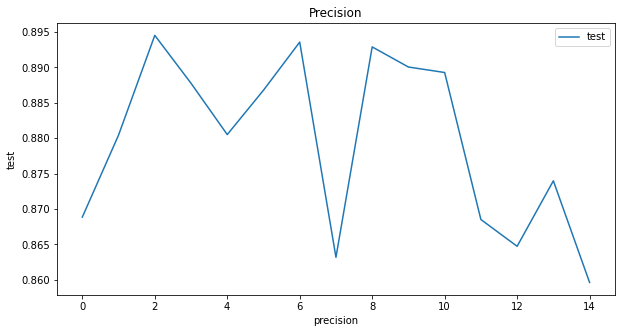


Iteration: 0750 of 10000		 Valid Loss: 0.4924

 acc 0.82666666666666643
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274, 0.8266666666666664]


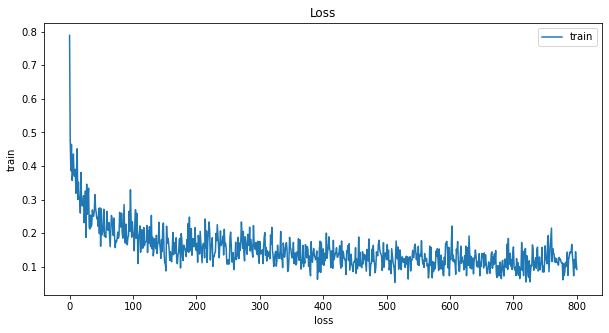

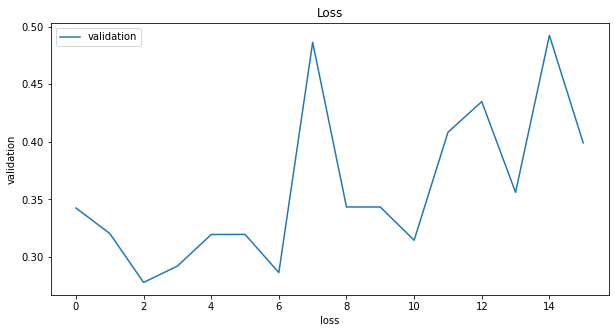

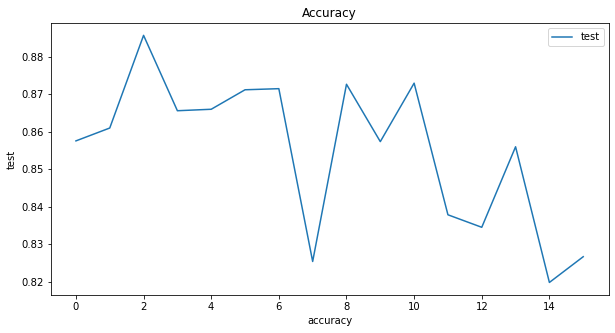

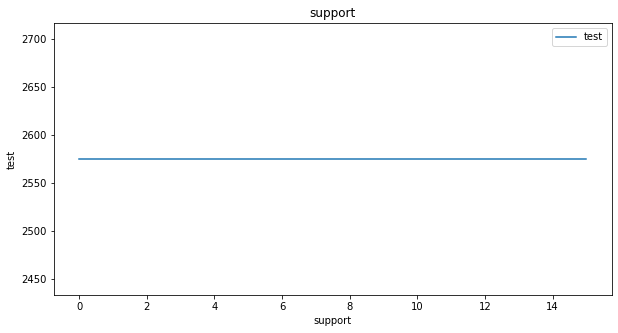

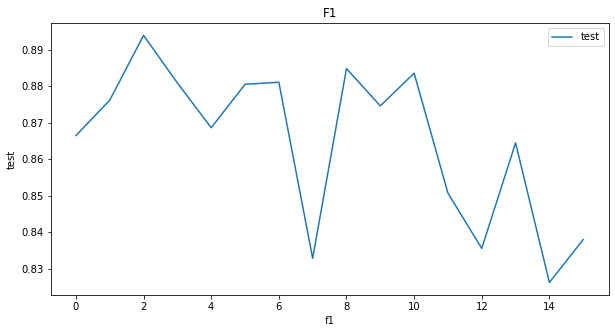

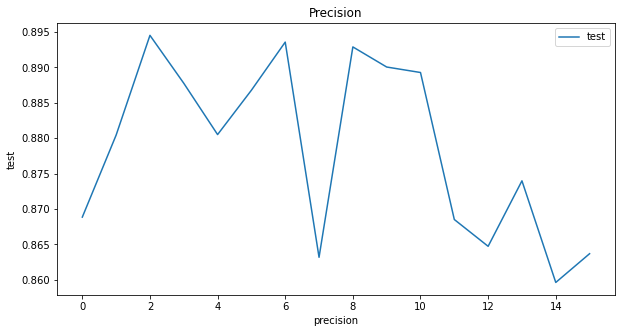


Iteration: 0800 of 10000		 Valid Loss: 0.3991

 acc 0.85196078431372564
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274, 0.8266666666666664, 0.8519607843137256]


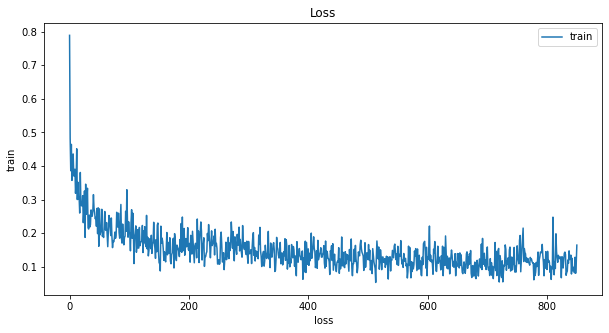

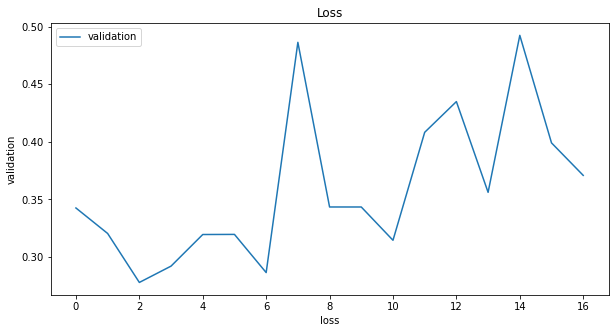

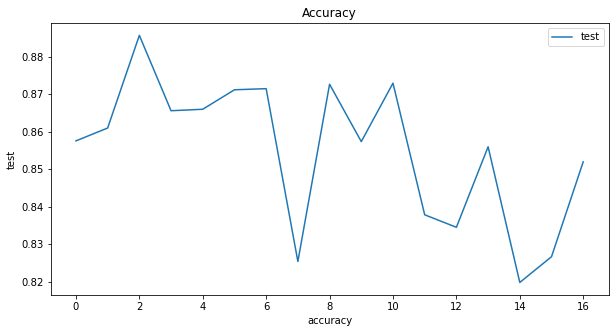

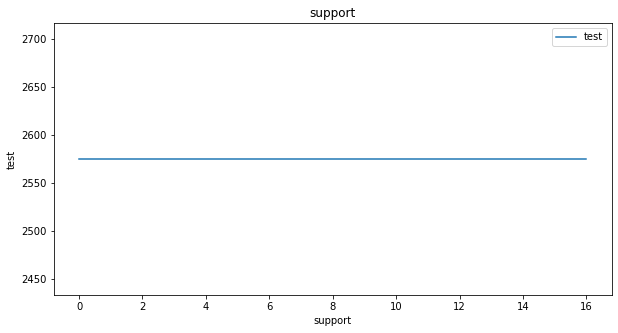

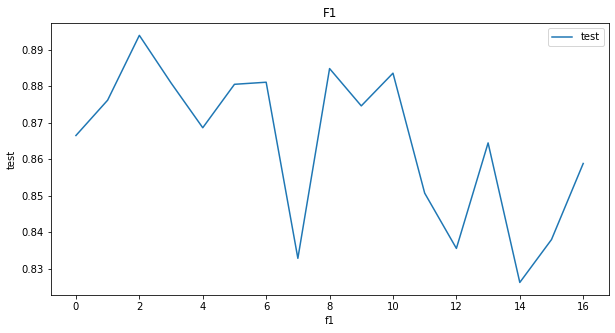

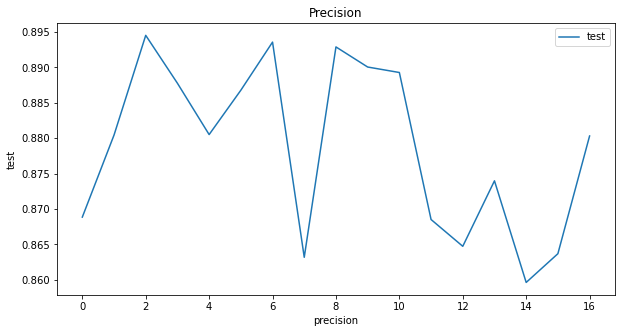


Iteration: 0850 of 10000		 Valid Loss: 0.3709

 acc 0.84401960784313712
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274, 0.8266666666666664, 0.8519607843137256, 0.8440196078431371]


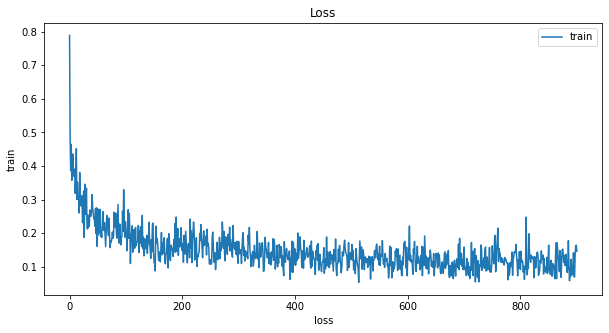

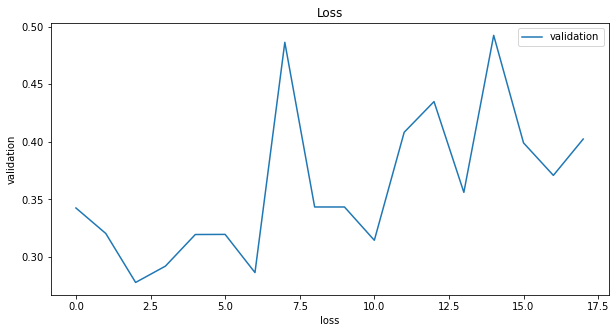

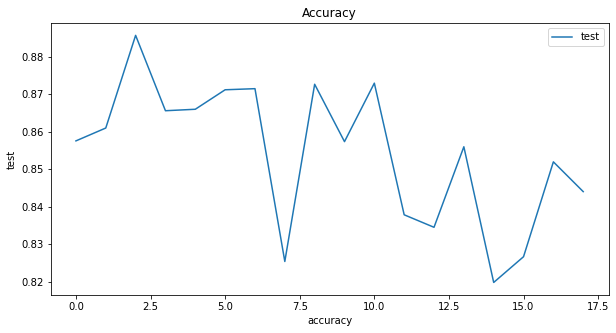

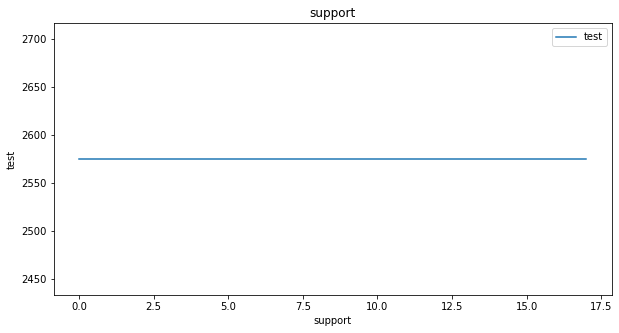

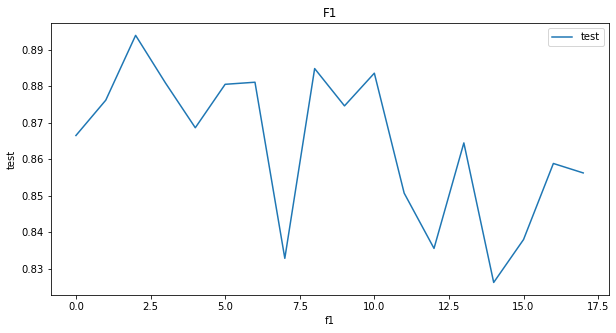

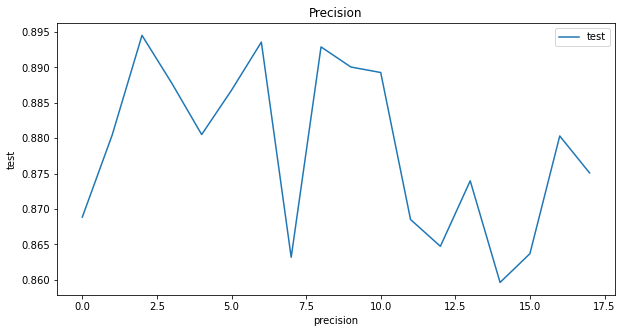


Iteration: 0900 of 10000		 Valid Loss: 0.4024

 acc 0.85705882352941184
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274, 0.8266666666666664, 0.8519607843137256, 0.8440196078431371, 0.8570588235294118]


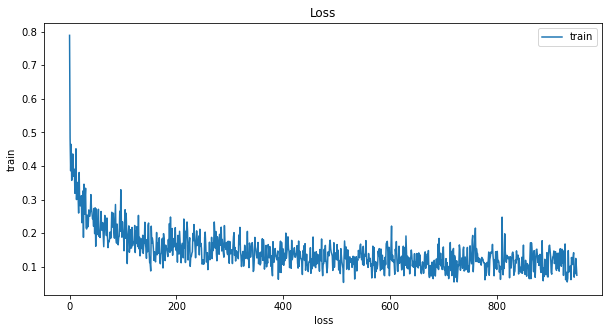

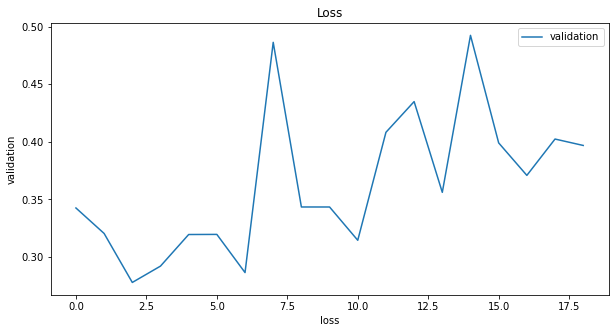

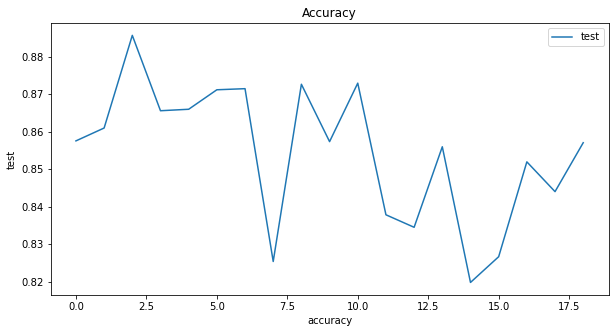

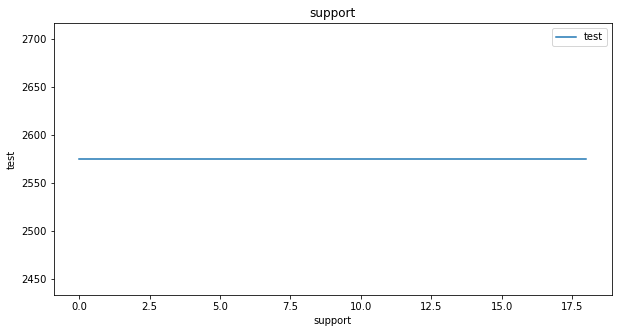

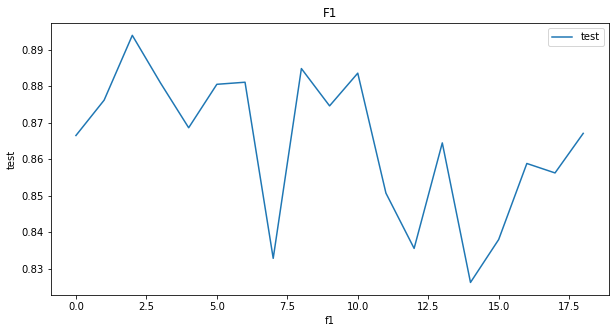

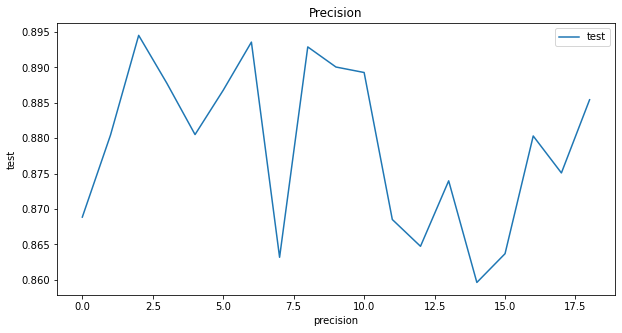


Iteration: 0950 of 10000		 Valid Loss: 0.3969

 acc 0.834803921568627478
 list acc [0.8575490196078431, 0.8609803921568627, 0.8856862745098039, 0.8655882352941175, 0.8659803921568627, 0.8711764705882354, 0.8714705882352941, 0.8253921568627453, 0.8726470588235292, 0.8573529411764704, 0.8729411764705881, 0.837843137254902, 0.8345098039215687, 0.855980392156863, 0.8198039215686274, 0.8266666666666664, 0.8519607843137256, 0.8440196078431371, 0.8570588235294118, 0.8348039215686274]


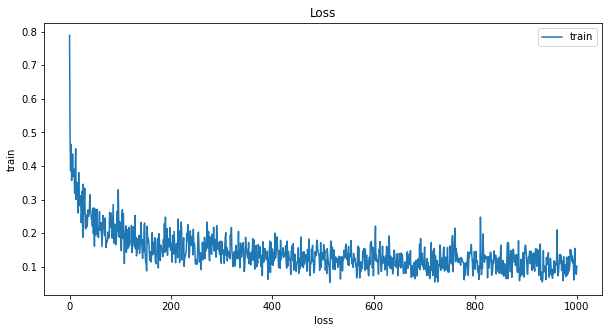

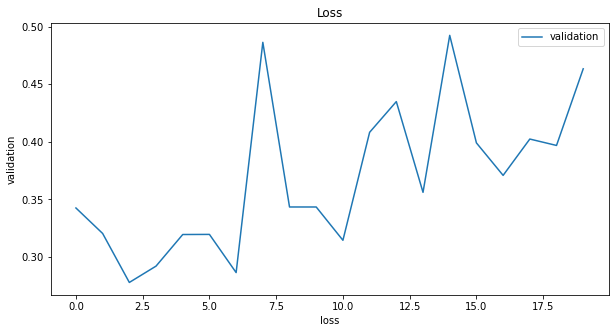

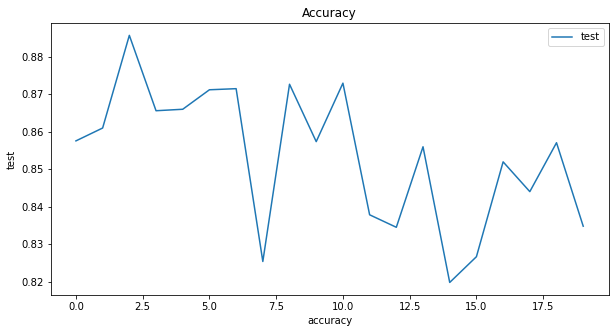

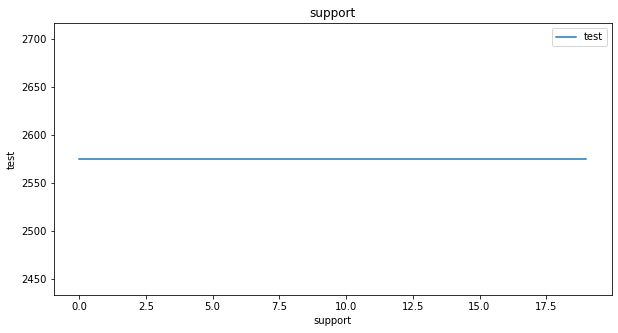

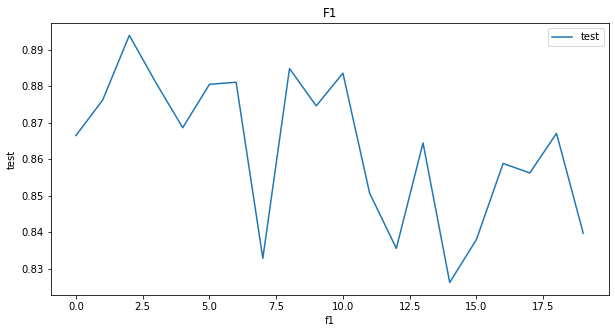

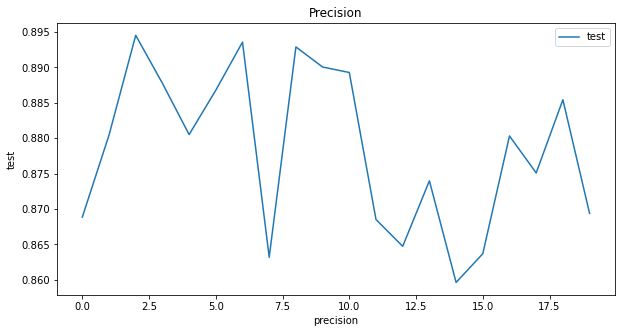


Iteration: 1000 of 10000		 Valid Loss: 0.4634



In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('always')

model = CamelyonClassifier()

dataset_train = PatchCamelyon(mode='train', batch_size=256, augment=False)
dataset_valid = PatchCamelyon(mode='valid', batch_size=100)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=100, shuffle=True, num_workers=0)


optimizer = optim.Adam(model.parameters(), lr=4e-4, betas=(0.9, 0.999), weight_decay=1e-8)
# Loss function
#criterion = loss
criterion = nn.BCEWithLogitsLoss()

def train():
    model.train()

    losses = []
    
    val_losses = []
    accuracies = []
    f1s = []
    supports = []
    precisions = []
    for iteration, (images, labels) in enumerate(train_loader):

        # Zero gradient
        optimizer.zero_grad()

        # Load data to GPU
        #sample = dataset_train[idx]
        #images = sample['images']
        #labels = sample['labels']

        # Forward pass
        predicted = model(images)

        # Loss
        loss = criterion(predicted, labels.float())
        losses.append(loss.item())

        # Back-propagation
        loss.backward()
        optimizer.step()

        print("{}\t\t Train Loss: {:.4f}".format(iteration, np.mean(losses[-100:])),
              end="\r")
        
        #if iteration != 0 and iteration % 20 == 0:
        #    plot('loss', 'train', 'Loss', np.arange(len(losses)), losses)
        
        if iteration != 0 and iteration % 50 == 0:
            with torch.no_grad():
                val_loss, accuracy, f1, support, precision = validation()
                
                
                print(f' acc {accuracy}')

                val_losses.append(val_loss)
                accuracies.append(accuracy)
                f1s.append(f1)
                supports.append(support)
                precisions.append(precision)
                
                print(f' list acc {accuracies}')

            # Get loss and metrics from validation set
 
            
            # Plot train and validation loss
            plot('loss', 'train', 'Loss', np.arange(len(losses)), losses)
            plot('loss', 'validation', 'Loss',np.arange(len(val_losses)),  val_losses)

            # Plot metrics
            plot('accuracy', 'test', 'Accuracy',np.arange(len(accuracies)),  accuracies)
            plot('support', 'test', 'support',np.arange(len(supports)), supports)
            plot('f1', 'test', 'F1',np.arange(len(f1s)), f1s)
            plot('precision', 'test', 'Precision', np.arange(len(precisions)), precisions)

            # Print output
            print("\nIteration: {:04d} of {:04d}\t\t Valid Loss: {:.4f}".format(iteration, 10000, val_loss),
                  end="\n\n")

            # Set model to training mode again
            model.train()

        if iteration % 1000000 == 0:
            torch.save(model.state_dict(), 'models/model-{:05d}.pth'.format(iteration))
       

def validation():
    model.eval()

    losses = []
    accuracy = []
    f_1 = []
    supports = []
    precisions = []
    
    predictions = []
    true_values = []
    
    for iteration, (images, labels) in enumerate(valid_loader):

        # Forward pass
        predicted = model(images).detach()

        # Loss
        loss = criterion(predicted, labels.float())
        losses.append(loss.data.item())
        
        
        predictions += ((torch.sigmoid(predicted) > 0.5) * 1.0).tolist() #
        true_values += labels.tolist() #
        
        
        precision,recall,f1,support = score(true_values, predictions)
        
        # scikit learn classification report
        
#         # DELETE ALL THIS USE SCIKITLEARN
        prediction_binary = torch.ge(predicted, 0.5).float()
        N = labels.numel()

#         # True positives, true negative, false positives, false negatives calculation
        tp = torch.nonzero(prediction_binary * labels).shape[0]
        tn = torch.nonzero((1 - prediction_binary) * (1 - labels)).shape[0]
#         fp = torch.nonzero(prediction_binary * (1 - labels)).shape[0]
#         fn = torch.nonzero((1 - prediction_binary) * labels).shape[0]

#         # Metrics
        acc = (tp + tn) / N
#         prec = 0. if tp == 0 else tp / (tp + fp)
#         rcl = 0. if tp == 0 else tp / (tp + fn)
#         spec = 0. if tn == 0 else tn / (tn + fp)
#         f_1 = 0. if prec == 0 or rcl == 0 else (2 * prec * rcl) / (prec + rcl)
        

#         metrics = {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'support': support}

        accuracy.append(acc)
        f_1.append(f1)
        supports.append(support)
        precisions.append(precision)
        if iteration > 100:
            break
        

    return np.array(losses).mean(), np.array(accuracy).mean(), \
            np.array(f_1).mean(), np.array(supports).mean(), \
            np.array(precisions).mean()

if __name__ == '__main__':
    train()